# Lab 4: Data engineering pipelines with scikit-learn

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

## Applying data transformations (recap from lecture)
* Data transformations should always follow a `fit-predict` paradigm
    * `Fit` the transformer on the **training data** only
        * E.g. for a standard scaler: record the mean and standard deviation
    * Transform (e.g. scale) the **training data**, then train the learning model
    * Transform (e.g. scale) the **test data**, then evaluate the model
* Only scale the input features (X), not the targets (y)!
* If you fit and transform the whole dataset before splitting, you get **data leakage**
    * You have looked at the test data before training the model
    * Model evaluations will be misleading
* If you fit and transform the training and test data separately, you distort the data
    * E.g. training and test points are scaled differently

### In practice (scikit-learn)

``` python
# choose scaling method and fit on training data
scaler = StandardScaler()
scaler.fit(X_train)

# transform training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

Alternative:

``` python
# calling fit and transform in sequence
X_train_scaled = scaler.fit(X_train).transform(X_train)
# same result, but more efficient computation
X_train_scaled = scaler.fit_transform(X_train)
```

### Scikit-learn processing pipelines
* Scikit-learn pipelines have a `fit`, `predict`, and `score` method 
    * Internally applies transformations correctly

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/07_pipelines.png" alt="ml" style="width: 600px;"/>

## Building Pipelines
* In scikit-learn, a `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be transformer (have a `transform` method)
    * The last step can be a transformer too (e.g. Scaler+PCA)
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
* Pipelines are built as a list of steps, which are (name, algorithm) tuples
    * The name can be anything you want, but can't contain `'__'`
    * We use `'__'` to refer to the hyperparameters, e.g. `svm__C`
* Let's build, train, and score a `MinMaxScaler` + `LinearSVC` pipeline:

``` python
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])
pipe.fit(X_train, y_train).score(X_test, y_test)
```

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


* Now with cross-validation:
``` python
scores = cross_val_score(pipe, cancer.data, cancer.target)
```

In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, cancer.data, cancer.target)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.98245614 0.97368421 0.96491228 0.96491228 0.99115044]
Average cross-validation score: 0.98


* We can retrieve the trained SVM by querying the right step indices
``` python
pipe.steps[1][1]
```

In [4]:
pipe.fit(X_train, y_train)
print("SVM component: {}".format(pipe.steps[1][1]))

SVM component: LinearSVC()


* Or we can use the `named_steps` dictionary
``` python
pipe.named_steps['svm']
```

In [5]:
print("SVM component: {}".format(pipe.named_steps['svm']))

SVM component: LinearSVC()


* When you don't need specific names for specific steps, you can use `make_pipeline`
    * Assigns names to steps automatically
``` python
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))
```

In [6]:
from sklearn.pipeline import make_pipeline
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('linearsvc', LinearSVC(C=100))]


Visualization of a pipeline `fit` and `predict`

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/07_pipelines.png" alt="ml" style="width: 700px;"/>

### Pipeline selection
* We can safely use pipelines in model selection (e.g. grid search)
* Use `'__'` to refer to the hyperparameters of a step, e.g. `svm__C`

``` python
# Correct grid search (can have hyperparameters of any step)
param_grid = {'svm__C': [0.001, 0.01],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X,y)
# Best estimator is now the best pipeline
best_pipe = grid.best_estimator_

# Tune pipeline and evaluate on held-out test set
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X_train,y_train)
grid.score(X_test,y_test)

```

### Using Pipelines in Grid-searches
* We can use the pipeline as a single estimator in `cross_val_score` or `GridSearchCV`
* To define a grid, refer to the hyperparameters of the steps
    * Step `svm`, parameter `C` becomes `svm__C`

In [7]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [8]:
from sklearn import pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.97
Test set score: 0.97
Best parameters: {'svm__C': 10, 'svm__gamma': 1}


* When we request the best estimator of the grid search, we'll get the best pipeline
``` python
grid.best_estimator_
```

In [9]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC(C=10, gamma=1))])


* And we can drill down to individual components and their properties
``` python
grid.best_estimator_.named_steps["svm"]
```

In [10]:
# Get the SVM
print("SVM step:\n{}".format(
      grid.best_estimator_.named_steps["svm"]))

SVM step:
SVC(C=10, gamma=1)


In [11]:
# Get the SVM dual coefficients (support vector weights)
print("SVM support vector coefficients:\n{}".format(
      grid.best_estimator_.named_steps["svm"].dual_coef_))

SVM support vector coefficients:
[[ -1.39188844  -4.06940593  -0.435234    -0.70025696  -5.86542086
   -0.41433994  -2.81390656 -10.         -10.          -3.41806527
   -7.90768285  -0.16897821  -4.29887055  -1.13720135  -2.21362118
   -0.19026766 -10.          -7.12847723 -10.          -0.52216852
   -3.76624729  -0.01249056  -1.15920579 -10.          -0.51299862
   -0.71224989 -10.          -1.50141938 -10.          10.
    1.99516035   0.9094081    0.91913684   2.89650891   0.39896365
   10.           9.81123374   0.4124202   10.          10.
   10.           5.41518257   0.83036405   2.59337629   1.37050773
   10.           0.27947936   1.55478824   6.58895182   1.48679571
   10.           1.15559387   0.39055347   2.66341253   1.27687797
    0.65127305   1.84096369   2.39518826   2.50425662]]


### Grid-searching preprocessing steps and model parameters
* We can use grid search to optimize the hyperparameters of our preprocessing steps and learning algorithms at the same time
* Consider the following pipeline:
    - `StandardScaler`, without hyperparameters
    - `PolynomialFeatures`, with the max. _degree_ of polynomials
    - `Ridge` regression, with L2 regularization parameter _alpha_

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = pipeline.make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

* We don't know the optimal polynomial degree or alpha value, so we use a grid search (or random search) to find the optimal values
``` python
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)
```

In [13]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
# Note: I had to use n_jobs=1. (n_jobs=-1 stalls on my machine)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train);

* Visualing the $R^2$ results as a heatmap:

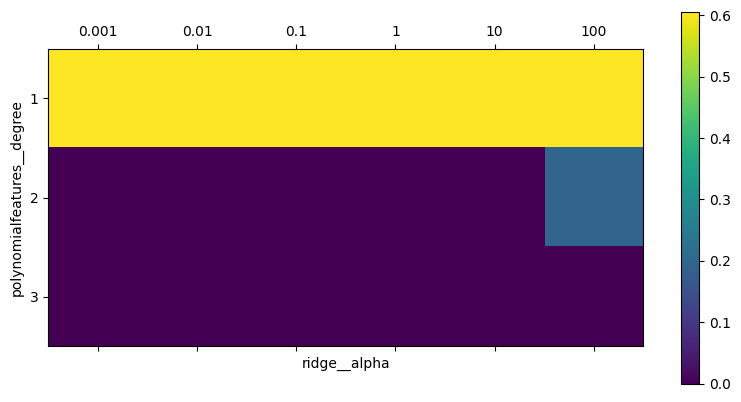

In [14]:
import matplotlib.pyplot as plt

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar();

/Users/jvanscho/miniconda3/envs/mlcourse/lib/python3.10/site-packages/sklearn/datasets/_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


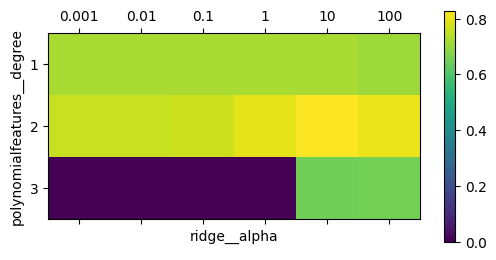

In [15]:
# Another example (different dataset)

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train);

#plot
fig, ax = plt.subplots(figsize=(6, 3))
im = ax.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
ax.set_xlabel("ridge__alpha")
ax.set_ylabel("polynomialfeatures__degree")
ax.set_xticks(range(len(param_grid['ridge__alpha'])))
ax.set_xticklabels(param_grid['ridge__alpha'])
ax.set_yticks(range(len(param_grid['polynomialfeatures__degree'])))
ax.set_yticklabels(param_grid['polynomialfeatures__degree'])
plt.colorbar(im);

* Here, degree-2 polynomials help (but degree-3 ones don't), and tuning the alpha parameter helps as well.
* Not using the polynomial features leads to suboptimal results (see the results for degree 1)

In [16]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


### FeatureUnions
- Sometimes you want to apply multiple preprocessing techniques and use the _combined_ produced features
- Simply appending the produced features is called a `FeatureJoin`
- Example: Apply both PCA and feature selection, and run an SVM on both

In [17]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Combined space has 3 features
Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=3)),
                                                ('univ_select',
                                                 SelectKBest(k=1))])),
                ('svm', SVC(C=10, kernel='linear'))])


### ColumnTransformer
- A pipeline applies a transformer on _all_ columns
    - If your dataset has both numeric and categorical features, you often want to apply different techniques on each
    - You _could_ manually split up the dataset, and then feature-join the processed features (tedious)
- `ColumnTransformer` allows you to specify on which columns a preprocessor has to be run
    - Either by specifying the feature names, indices, or a binary mask
- You can include multiple transformers in a ColumnTransformer
    - In the end the results will be feature-joined
    - Hence, the order of the features will change!
        The features of the last transformer will be at the end
- Each transformer can be a pipeline
    - Handy if you need to apply multiple preprocessing steps on a set of features
    - E.g. use a ColumnTransformer with one sub-pipeline for numerical features and one for categorical features.
- In the end, the columntransformer can again be included as part of a pipeline
    - E.g. to add a classfier and include the whole pipeline in a grid search

``` python
# 2 sub-pipelines, one for numeric features, other for categorical ones
numeric_pipe = make_pipeline(SimpleImputer(),StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(),OneHotEncoder())

# Using categorical pipe for features A,B,C, numeric pipe otherwise
preprocessor = make_column_transformer((categorical_pipe,
                                        ["A","B","C"]), 
                                        remainder=numeric_pipe)

# Combine with learning algorithm in another pipeline

``` python
pipe = make_pipeline(preprocessor, LinearSVC())
```


* Careful: `ColumnTransformer` concatenates features in order

``` python
pipe = make_column_transformer((StandardScaler(),numeric_features), 
                               (PCA(),numeric_features),
                               (OneHotEncoder(),categorical_features))
```

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/columntransformer.png" alt="ml" style="width: 900px;"/>

Example: Handle a dataset (Titanic) with both categorical an numeric features
- Numeric features: impute missing values and scale
- Categorical features: Impute missing values and apply one-hot-encoding
- Finally, run an SVM

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


You can again run optimize any of the hyperparameters (preprocessing-related ones included) in a grid search

In [19]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best logistic regression from grid search: 0.798
